# EXPLORATORY DATA ANALYSIS

This notebook includes EDA steps.

## Setting Up The Notebook

In [1]:
import random, os, warnings, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import missingno as msno

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split

## Load Data

In [2]:
FOLDER = ''
df = pd.read_csv(FOLDER + 'train.csv')
print('Total train data size:', df.shape)

Total train data size: (16784, 30)


## Data Dictionary

Data fields

    listing_id - the unique id for the listing of a used car
    title - title of the listing; free text attribute typically containing the make, model, engine type/size
    make - make/brand of the car
    model - model of the car (for the given make/brand)
    description - title of the listing; free text attribute
    manufactured - Year the car was manufactured
    original_reg_date - Original registration data; date format string
    reg_date - Registration data; date format string
    type_of_vehicle - Type of vehicle (e.g., "sports car", "luxury sedan")
    category - Category of the car; list of categories, comma-separated
    transmission - Type of transmission ("auto" or "manual")
    curb_weight - Weight in kg of the vehicle without any passenger or items
    power - Power of engine in kW
    fuel_type - Fuel type (e.g, "petrol", "diesel", "electric")
    engine_cap - Displacement of engine in cc (cubic centimeter)
    no_of_owners - Number of previous owners (>=1 since all cars are used)
    depreciation - Annual depreciation in SGD is the amount the owner loses on the value of the vehicle per year based on the assumption that the vehicle is deregistered only at the end of its 10-yr COE life-span
    coe - Certificate of entitlement value in SGD when first registered
    road_tax - Road tax value in SGD calculated based on the engine capacity on a per annum basis
    dereg_value - deregistration value in SGD one will get back from the government upon deregistering the vehicle for use in Singapore
    mileage - Number of kilometers driven
    omv - Open Market Value in SGD assessed by the Singapore Customs
    arf - Additional Registration Fee in SGD is a tax imposed upon registration of a vehicle
    opc_scheme - Off-peak car scheme
    lifespan - Date stated on the lifespan marks the day that the vehicle must be deregistered
    eco_category - Eco category of vehicle
    features - Noteworthy features; free text attribute
    accessories - Noteworthy accessories ; free text attribute
    indicative_price - General guide to the price in SGD of the vehicle
    price - Resale price in SGD of the car


## EDA

### Overview

This step observes the missing values in dataset. Followings are the observations:
- The column `original_reg_date` has the most number of empty values. 
- We also notice that the column `fuel_type` is missing ~80% of the values. This seems like an important column and could have a significant effect on the final price of the car. Maybe we could fill in the missing values from an external datasource?
- Similarly, `opc`, `lifespac` and `indicative_price` also have a large number of missing values.

listing_id               0
title                    0
make                  2160
model                    0
description            345
manufactured           194
original_reg_date    16466
reg_date               201
type_of_vehicle          0
category                 0
transmission             0
curb_weight            579
power                 2337
fuel_type            13294
engine_cap              53
no_of_owners           176
depreciation           433
coe                    891
road_tax              2154
dereg_value           1189
mileage               3724
omv                     41
arf                    284
opc_scheme           16577
lifespan             15082
eco_category             0
features               459
accessories           2813
indicative_price     16784
price                    0
dtype: int64


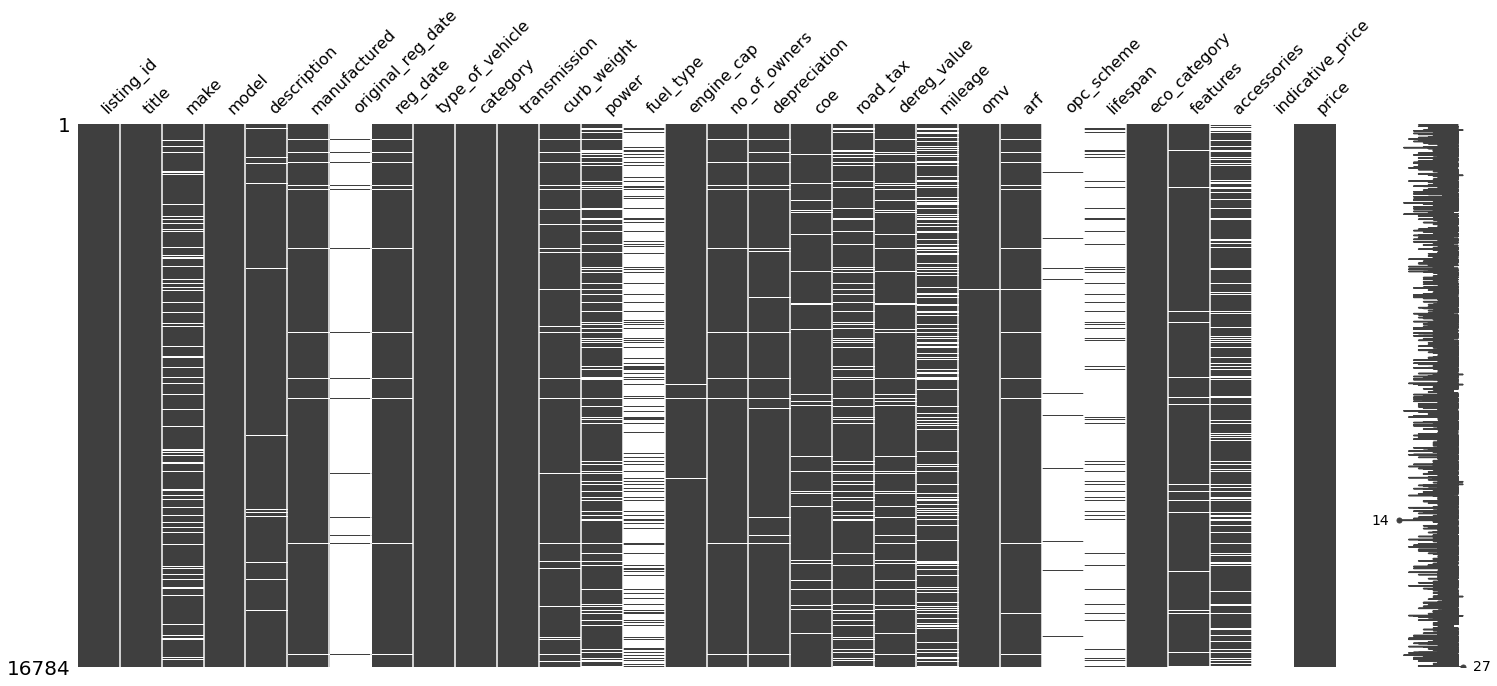

In [3]:
# checking missing values across all columns
print(df.isnull().sum())

# display missing values
msno.matrix(df)
plt.show()

<AxesSubplot:>

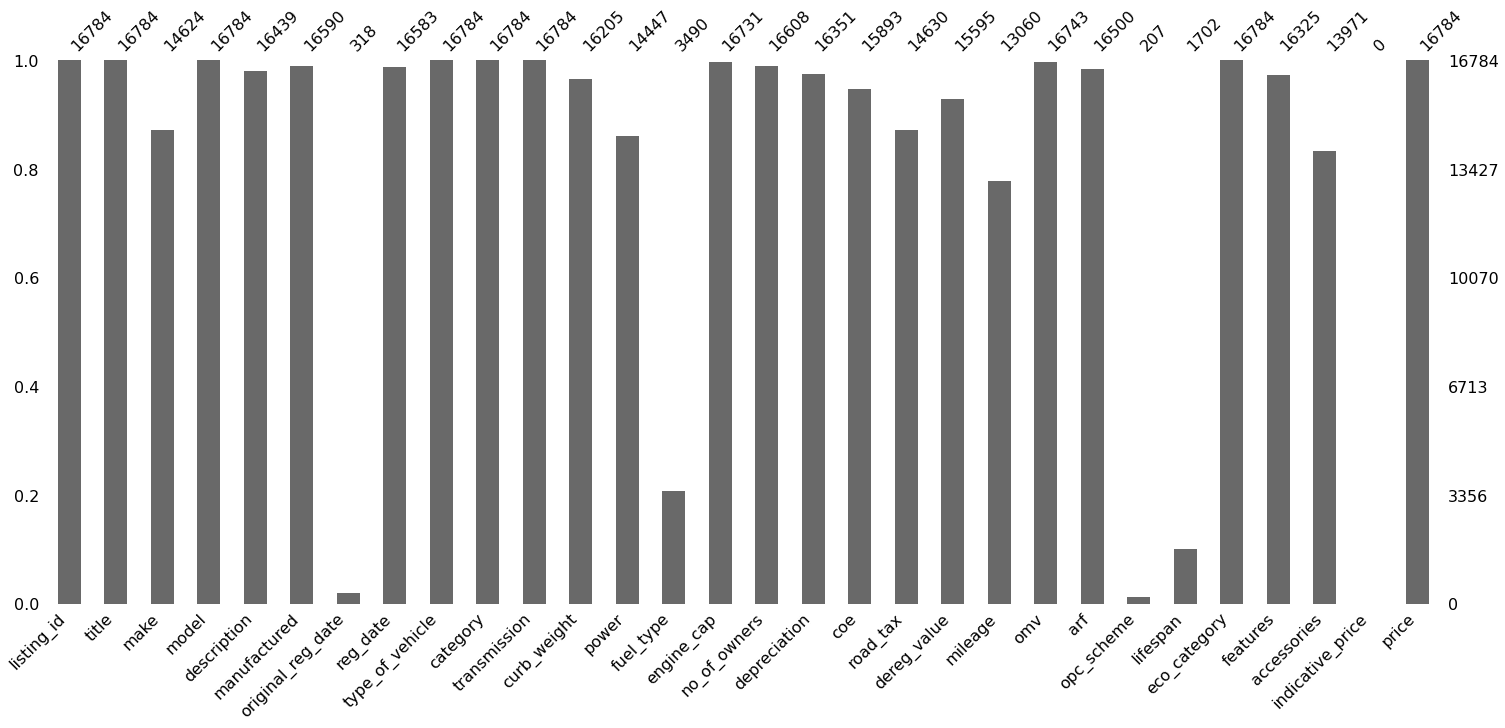

In [4]:
msno.bar(df)

<AxesSubplot:>

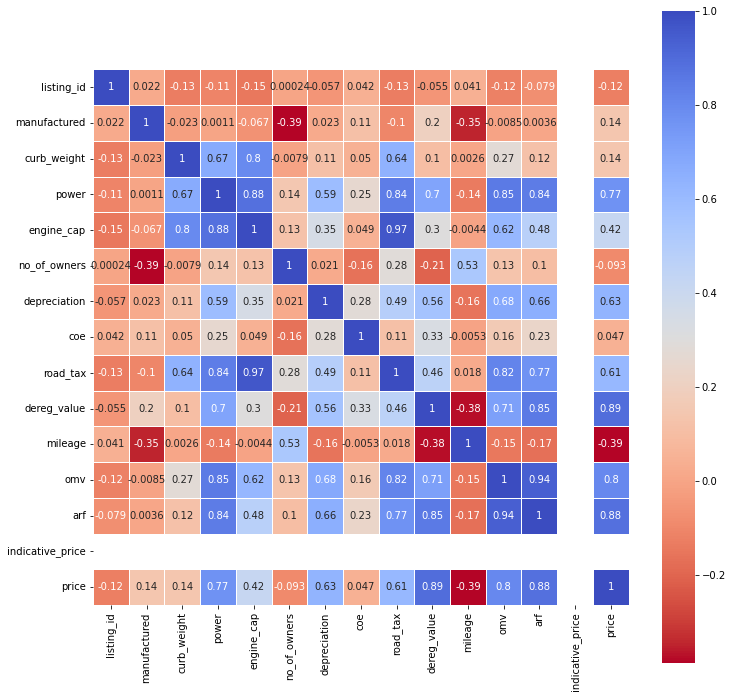

In [5]:
plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(), cmap='coolwarm_r', square=True, linewidth=.5, annot=True)

The above plot shows the pearson corelation between different features of the dataset. We can also visualize this using a dendrogram.

<AxesSubplot:>

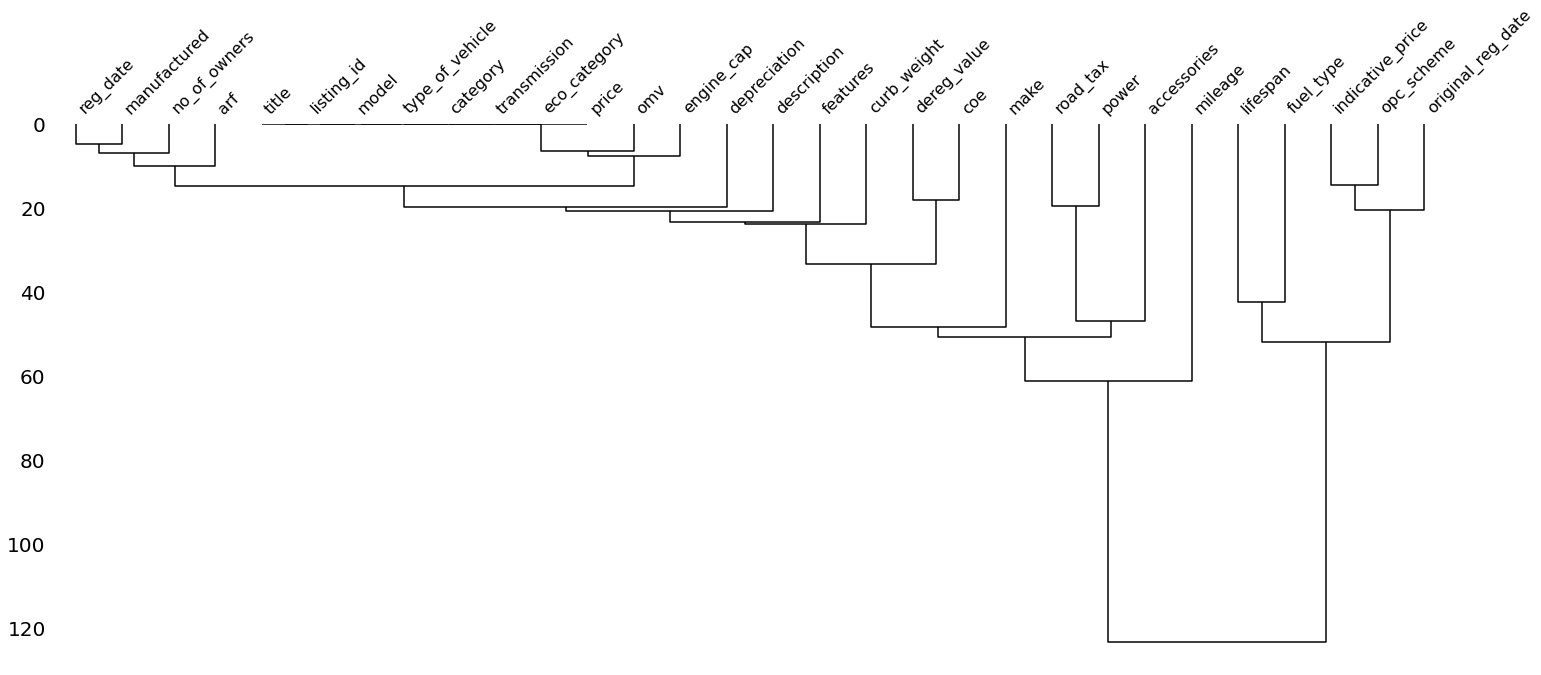

In [6]:
msno.dendrogram(df)

The dendrogram allows us to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap. 

The dendrogram uses a hierarchical clustering algorithm  to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.

We can already make a few observations:

- We see that the `no_of_owners` column is very strongly related to the `reg_date` and `manufactured` columns, which is intuitive since we would expect older cars to have more owners.
- We also see that the `power` of a car is closely related to the `road_tax` column, which is intuitive since we expect cars with higher power to have a higher road tax.
- There are also some spurious corelations present. For example, we see that the `indicative_price` and `opc_scheme` are closely related to each other, but this is only because most values in both these columns are null.
- There are also 2 level deep corelations present. For example, we see the columns `dereg_value` and `coe` are closely related to the other columns such as `curb_weight`, `description`, `features`, etc.

The next step is close check for each column, with observations explained.

### Title

- The `title` field always contains the make and the model of the car. Maybe we can use this information to fill in the missing values in the other columns.

count    16784.000000
mean        32.145436
std         11.182021
min          6.000000
25%         24.000000
50%         32.000000
75%         39.000000
max         84.000000
Name: title, dtype: float64


<AxesSubplot:ylabel='Frequency'>

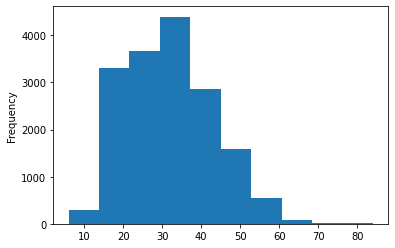

In [7]:
# describe title
print(df.title.str.len().describe())

# display title on histogram plot
df.title.str.len().plot(kind='hist')

### Make

- There are a total of 77 unique car manufacturers.
- The most common manufacturer is `toyota`.
- Out of there 77, ~50% have lesser than 23 records in the dataset. We could possibly combine there manufacturers in a single value.

unique: 77
toyota           2163
mercedes-benz    1967
bmw              1636
honda            1519
nissan           1091
                 ... 
daf                 1
international       1
dodge               1
rover               1
mitsuoka            1
Name: make, Length: 77, dtype: int64
count      77.000000
mean      189.922078
std       431.422395
min         1.000000
25%         2.000000
50%        23.000000
75%       106.000000
max      2163.000000
Name: make, dtype: float64


<AxesSubplot:ylabel='Frequency'>

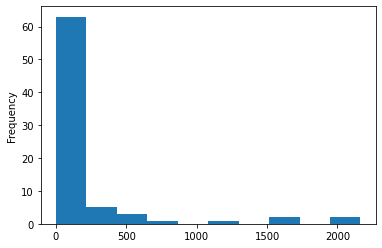

In [8]:
# check unique values on 'make'
print('unique:', df.make.nunique())

# count records for each unique value
print(df.make.value_counts())

# describe 'make'
print(df.make.value_counts().describe())

# display 'make' on histogram
df.make.value_counts().plot(kind='hist')

### Model

- There are 692 unique car models.
- Out of the 692 models, ~50% have less than 5 records in the dataset. 
- **Idea**: Create segments for the cars based on the model and make. This will help reduce the number of unique values from both these columns.

amg          575
corolla      479
vezel        394
civic        380
cerato       353
            ... 
gransport      1
ff             1
900s           1
corsa          1
14.280         1
Name: model, Length: 692, dtype: int64
count    692.000000
mean      24.254335
std       57.276252
min        1.000000
25%        1.000000
50%        5.000000
75%       19.000000
max      575.000000
Name: model, dtype: float64


<AxesSubplot:ylabel='Frequency'>

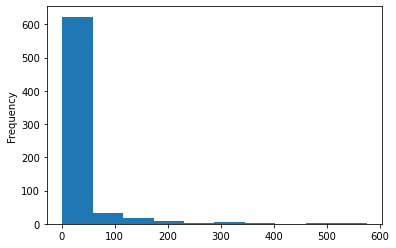

In [9]:
# check unique values on 'model'
df.model.nunique()

# count records for each unique value
print(df.model.value_counts())

# describe 'make'
print(df.model.value_counts().describe())

# display 'make' on histogram
df.model.value_counts().plot(kind='hist')

### Description

- All listings have a description.
- The description usually has information that could be used to fill other missing values such as COE, availability of loan, etc.

AxesSubplot(0.125,0.125;0.775x0.755)
count    16439.000000
mean       219.342843
std        126.340324
min          1.000000
25%        133.000000
50%        232.000000
75%        326.000000
max        401.000000
Name: description, dtype: float64
description containing loan (9094, 30)
description containing coe (637, 30)


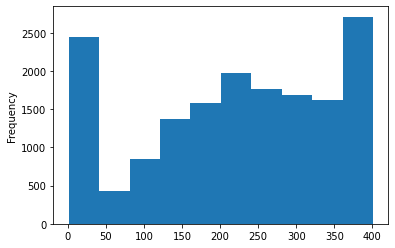

In [10]:
print(df.description.str.len().plot(kind='hist'))
print(df.description.str.len().describe())
print('description containing loan', df[df.description.fillna("na").str.contains("loan")].shape)
print('description containing coe', df[df.description.fillna("na").str.contains("coe")].shape)

### Manufactured 

- This particular field would need some data cleaning, since we have `manufactured` values well into the past and the future(year 2925!)

In [11]:
print(df.manufactured.value_counts())
print(df.manufactured.describe())

2016.0    2249
2018.0    1802
2017.0    1764
2019.0    1481
2015.0    1462
          ... 
1977.0       1
1964.0       1
1959.0       1
1967.0       1
1970.0       1
Name: manufactured, Length: 61, dtype: int64
count    16590.000000
mean      2014.212417
std          8.771572
min       1933.000000
25%       2011.000000
50%       2016.000000
75%       2018.000000
max       2925.000000
Name: manufactured, dtype: float64


### Original Reg Date

In [12]:
print('Number of missing values on original_reg_date:', df.original_reg_date.isnull().sum())
print(df.original_reg_date.value_counts())

Number of missing values on original_reg_date: 16466
25-sep-2020    3
29-jan-2021    3
11-mar-2021    2
14-dec-2020    2
28-sep-2018    2
              ..
15-jun-2020    1
07-jul-2020    1
09-aug-2018    1
31-may-2020    1
23-mar-2021    1
Name: original_reg_date, Length: 273, dtype: int64


### Reg Date

In [13]:
df.reg_date = df.reg_date.apply(pd.to_datetime)
print(df.reg_date.value_counts())
print(df.reg_date.describe(datetime_is_numeric=True))

2017-12-29    41
2017-02-28    28
2018-11-30    28
2018-06-29    26
2015-06-30    25
              ..
2004-12-03     1
2021-05-18     1
2008-02-23     1
2009-01-03     1
2009-09-19     1
Name: reg_date, Length: 3889, dtype: int64
count                            16583
mean     2015-03-01 23:21:42.321654528
min                1969-05-02 00:00:00
25%                2011-08-31 00:00:00
50%                2016-06-28 00:00:00
75%                2018-07-30 00:00:00
max                2022-01-01 00:00:00
Name: reg_date, dtype: object


### Type of Vehicle

In [14]:
print('Unique:', df.type_of_vehicle.nunique())
print(df.type_of_vehicle.value_counts())
print('number of missing values on type_of_vehicle:', df.type_of_vehicle.isnull().sum())

Unique: 11
suv                3104
luxury sedan       3059
mid-sized sedan    2634
sports car         2024
hatchback          1828
mpv                1821
van                1076
truck               751
stationwagon        352
bus/mini bus        107
others               28
Name: type_of_vehicle, dtype: int64
number of missing values on type_of_vehicle: 0


### Category

<AxesSubplot:>

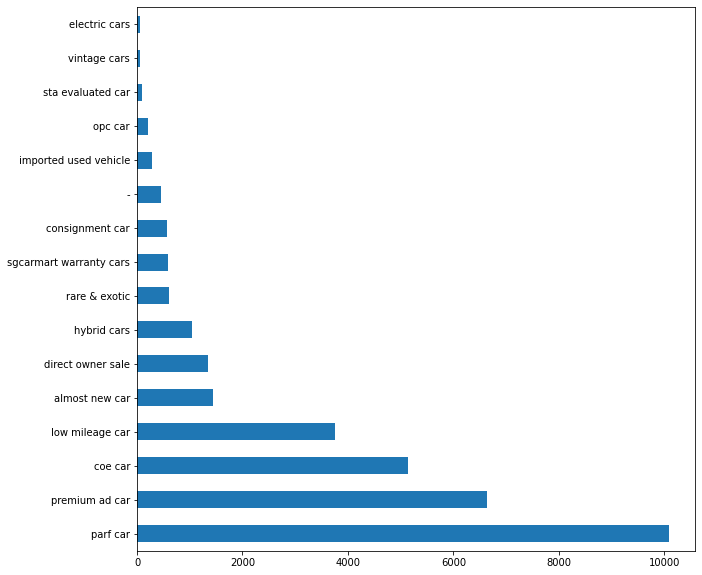

In [15]:
tdf_category = df.category.str.split(",")
tdf_category = tdf_category.apply(lambda record: [x.strip() for x in record])
pd.Series(np.concatenate(tdf_category.values)).value_counts().plot(kind='barh', figsize=(10,10))

### Transmission

missing values on transmission column: 0


<AxesSubplot:>

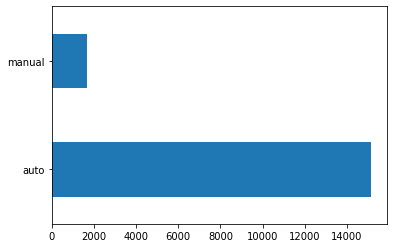

In [16]:
print('missing values on transmission column:', df.transmission.isnull().sum())
df.transmission.value_counts().plot(kind='barh')

### Curb Weight

- There are a few missing value for the `curb_weight` column, but these can most likely be filled by using the weights from the matching car `category` and `make` columns

In [17]:
print(df.curb_weight.describe())
print(df[df.curb_weight > 2000].curb_weight)

count    16205.000000
mean      1554.616230
std        820.442216
min          2.000000
25%       1280.000000
50%       1440.000000
75%       1680.000000
max      20980.000000
Name: curb_weight, dtype: float64
7         2080.0
17        2075.0
29        2215.0
35        2030.0
36        2305.0
          ...   
16721     2420.0
16732     2350.0
16768    10620.0
16772     2560.0
16779     2053.0
Name: curb_weight, Length: 1068, dtype: float64


In [18]:
df[df.curb_weight.isnull()]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
5,1027957,Mercedes-Benz A-Class A35 AMG 4MATIC Premium Plus,mercedes-benz,a35,one and only a35 with a45 features in sg! bidd...,NaN,25-dec-2020,NaT,sports car,"imported used vehicle, coe car",...,NaN,34000.0,NaN,NaN,NaN,uncategorized,powered by a newly developed 2 litre four cyli...,"fitted with amg aero package, amg performance ...",NaN,273800.0
42,953072,BMW 7 Series 740Li M-Sport,bmw,740li,"please call for an appointment, trade in welco...",NaN,NaN,2020-12-16,luxury sedan,"parf car, almost new car, premium ad car, low ...",...,652.0,98984.0,150172.0,NaN,NaN,uncategorized,"powered by bmw twinpower turbo inline 6, 8 spe...","new unit! m-sport plus package, head up displa...",NaN,491700.0
76,990220,Mercedes-Benz E-Class E200 Mild Hybrid AMG Line,NaN,amg,"unregistered,graphite gray - metallic finish, ...",NaN,21-apr-2021,NaT,luxury sedan,"imported used vehicle, coe car, low mileage ca...",...,8.0,51000.0,NaN,NaN,NaN,uncategorized,graphite gray metallic finish 2021 new model e...,smartphone integration with wireless charging....,NaN,247400.0
94,1018128,Mercedes-Benz E-Class E200 (COE till 03/2029),mercedes-benz,e200,700,1999.0,NaN,1999-10-12,luxury sedan,"coe car, premium ad car",...,NaN,53994.0,75592.0,NaN,NaN,uncategorized,view specs of the mercedes-benz e-class,NaN,NaN,51500.0
199,1017335,Toyota Alphard 2.5A S,toyota,alphard,"3 years or 100,000km mileage warranty! contact...",NaN,19-oct-2018,NaT,mpv,"imported used vehicle, coe car, low mileage car",...,16500.0,19172.0,NaN,NaN,NaN,uncategorized,powerful and reliable 205l dual vvti 4 cylinde...,"automatic sliding door, reverse camera, parkin...",NaN,184800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16739,948034,Mercedes-Benz A-Class A200 AMG Line,mercedes-benz,a200,"new 2020 a200 amg 5 years warranty, loan avail...",2020.0,NaN,2020-11-24,hatchback,"parf car, almost new car, low mileage car",...,80.0,28761.0,32266.0,NaN,NaN,uncategorized,"powered by 4 cylinders inline, 16 valves produ...","amg body styling, 18"" wheels, keyless go, spor...",NaN,159500.0
16753,982435,Mazda RX7 Efini (New 10-yr COE),mazda,rx7,legendary unit from uncle 9389 to our legend a...,1993.0,NaN,1994-01-17,sports car,"coe car, low mileage car",...,45968.0,57283.0,85925.0,NaN,NaN,uncategorized,fully loaded parts and one of the best chasis ...,100% in house loan available and low interest ...,NaN,757600.0
16758,1005091,Mercedes-Benz CLA-Class CLA45 S AMG 4MATIC+ Plus,mercedes-benz,amg,newly registration unit! comes with 5 years wa...,2020.0,NaN,2021-06-14,sports car,"parf car, almost new car, premium ad car, low ...",...,652.0,68561.0,95410.0,NaN,NaN,uncategorized,powered by a 2.0cc 4 cylinders inline engine p...,"plus spec. adaptive damping system, panoramic ...",NaN,357500.0
16763,1007170,Ford Ranger Raptor Double-Cab 2.0A EcoBlue,ford,ranger,"almost new unit. flexible loan arrangements, c...",NaN,23-mar-2021,NaT,truck,"imported used vehicle, coe car, low mileage car",...,50.0,888.0,NaN,NaN,NaN,uncategorized,performance 157kw torque 500nm fuel consumpti...,"fox suspension, ford infotainment system with ...",NaN,194600.0


### Power

- Similar to the `curb_weight` column, the missing values in the `power` column can be filled using the power from the matching car `category` and `make` columns.

In [19]:
print(df.power.describe())
print('missing values on power column:', df.power.isnull().sum())

count    14447.000000
mean       133.950647
std         74.294299
min         40.500000
25%         90.000000
50%        110.000000
75%        147.000000
max        552.000000
Name: power, dtype: float64
missing values on power column: 2337


### Fuel Type

- While `fuel_type` seems like an important indicator of the final price of the car, ~79% of the values are missing in this field. This could possibly be fixed with external data.
- We could also just ignore this field during modelling.

missing values on fuel_type column: 13294
percentage of missing values: 0.7920638703527169
AxesSubplot(0.125,0.125;0.775x0.755)


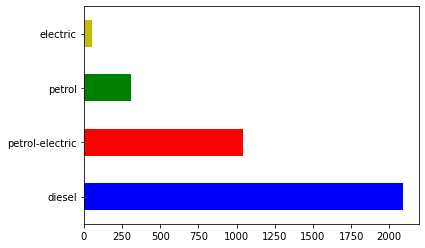

In [20]:
print('missing values on fuel_type column:', df.fuel_type.isnull().sum())
print('percentage of missing values:', df.fuel_type.isnull().sum()/df.shape[0])
print(df.fuel_type.value_counts().plot(kind='barh', color=['b','r','g','y']))

### Engine Cap

In [21]:
print(df.engine_cap.describe())
print('missing values on engine_cap column:', df.engine_cap.isnull().sum())

count    16731.000000
mean      2086.423944
std       1126.062034
min          0.000000
25%       1497.000000
50%       1797.000000
75%       2356.000000
max      15681.000000
Name: engine_cap, dtype: float64
missing values on engine_cap column: 53


### No of Owners

- Majority of the cars ~49.4% have had only 1 previous owner. Inituitively, these cars should be better price than the other similar cars which have had more owners.
- There are also a few missing values in this column, but we could safely fill these values with the number `1`, since it is guaranteed that each of these cars would've had atleast 1 owner.

missing values on no_of_owners column: 176
percentage of missing values: 0.4937440419447092
AxesSubplot(0.125,0.125;0.775x0.755)


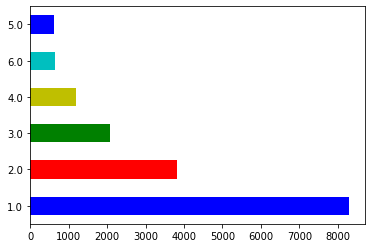

In [22]:
print("missing values on no_of_owners column:",df.no_of_owners.isnull().sum())
print("percentage of missing values:", df[df.no_of_owners == 1].shape[0]/df.shape[0])
print(df.no_of_owners.value_counts().plot(kind='barh', color=['b','r','g','y', 'c']))

### Depreciation

In [23]:
print(df.depreciation.describe())
print('missing values on depreciation column:', df.depreciation.isnull().sum())

count     16351.000000
mean      14489.055104
std       19367.989982
min        2680.000000
25%        8630.000000
50%       10610.000000
75%       14870.000000
max      865610.000000
Name: depreciation, dtype: float64
missing values on depreciation column: 433


### COE

In [24]:
print(df.coe.describe())
print('missing values on depreciation column:', df.coe.isnull().sum())

count    15893.000000
mean     41336.704524
std      16553.755676
min         10.000000
25%      31335.000000
50%      40512.000000
75%      51600.000000
max      97889.000000
Name: coe, dtype: float64
missing values on depreciation column: 891


### Road Tax

- We could fill in the missing values for the road tax using the formula specified in the calculator [here](https://www.sgcarmart.com/services/roadtax_calculator.php)

In [25]:
print('missing values on depreciation column:', df.road_tax.isnull().sum())
print(df.road_tax.describe())
print(df[df.road_tax.isnull()].make.value_counts())

missing values on depreciation column: 2154
count    14630.000000
mean      1358.951880
std       1187.558721
min         50.000000
25%        684.000000
50%        976.000000
75%       1369.000000
max      12375.000000
Name: road_tax, dtype: float64
nissan           620
toyota           394
mitsubishi       154
mercedes-benz    116
isuzu            109
suzuki            46
fiat              39
hino              37
volkswagen        34
citroen           29
peugeot           23
honda             20
renault           19
hyundai           17
bmw               17
kia               14
land rover        14
byd               12
opel              10
porsche            9
scania             8
maxus              7
audi               7
ford               6
austin             6
ssangyong          5
ud                 5
foton              4
alfa romeo         3
man                3
mini               3
mazda              2
tesla              2
morris             2
golden dragon      2
yutong        

### Dereg Value

In [26]:
print('missing values on dereg_value column:', df.dereg_value.isnull().sum())
print(df.dereg_value.describe())

missing values on dereg_value column: 1189
count     15595.000000
mean      44208.937865
std       42816.473242
min          97.000000
25%       24985.000000
50%       35556.000000
75%       50403.500000
max      653862.000000
Name: dereg_value, dtype: float64


### Mileage

In [27]:
print('missing values on mileage column:', df.mileage.isnull().sum())
print(df.mileage.describe())

missing values on mileage column: 3724
count     13060.000000
mean      72539.375651
std       50985.924208
min           1.000000
25%       32661.500000
50%       65801.500000
75%      104000.000000
max      740459.000000
Name: mileage, dtype: float64


### OMV

In [28]:
df.omv.describe()

count    1.674300e+04
mean     3.896792e+04
std      4.445251e+04
min      8.880000e+02
25%      1.919300e+04
50%      2.708400e+04
75%      4.068750e+04
max      1.150000e+06
Name: omv, dtype: float64

### ARF

In [29]:
print(df.arf.describe())
print(df[['price', 'arf']].corr())

count     16500.000000
mean      38636.758242
std       59749.028200
min          63.000000
25%       12614.250000
50%       21698.000000
75%       42642.750000
max      858230.000000
Name: arf, dtype: float64
          price       arf
price  1.000000  0.884832
arf    0.884832  1.000000


### OPC Scheme

In [30]:
print('missing values on opc_scheme column:', df.opc_scheme.isnull().sum())
print(df.opc_scheme.value_counts())

missing values on opc_scheme column: 16577
revised opc scheme . learn more about opc schemes.    200
old opc scheme . learn more about opc schemes.          5
1100                                                    2
Name: opc_scheme, dtype: int64


### Lifespan

In [31]:
print('missing values on lifespan column:', df.lifespan.isnull().sum())
print(df.lifespan.value_counts())

missing values on lifespan column: 15082
31-dec-2041    23
29-mar-2041    12
04-aug-2041     9
12-aug-2041     9
30-may-2037     9
               ..
24-aug-2035     1
09-oct-2036     1
01-feb-2036     1
11-dec-2031     1
13-apr-2024     1
Name: lifespan, Length: 1115, dtype: int64


### Eco Category

- Since this column has only one value, we should drop it during the modelling phase.

In [32]:
df.eco_category.value_counts()

uncategorized    16784
Name: eco_category, dtype: int64

### Features

- The `features` column contains important information such as the capacity of the engine, air conditioning, etc. This could possibly be used during the modelling phase.

missing values on features column: 459
count    16325.000000
mean       140.917060
std         54.112462
min          1.000000
25%        124.000000
50%        165.000000
75%        180.000000
max        222.000000
Name: features, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


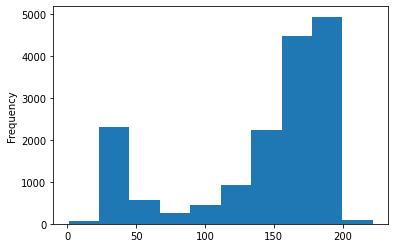

In [33]:
tdf = df.features
print('missing values on features column:', tdf.isnull().sum())
print(tdf.str.len().describe())
print(tdf.str.len().plot(kind='hist'))

### Accessories

In [34]:
tdf = df.accessories
print('missing values on accessories column:', tdf.isnull().sum())
tdf.head().apply(print)

missing values on accessories column: 2813
bmw i-drive, navigation, bluetooth/aux/usb input, reverse sensors, electric seats with memory, keyless entry, push start/stop.
factory radio setting. front recording camera. reverse sensor. carpet floorboard installed.
dual electric/memory seats. factory fitted audio system with bluetooth, reverse camera, parking assist. 18" sport rims, isofix. in-car camera.
64 colour ambient lighting. active parking assist, parktronic, reverse camera. memory seats. hands free access. media/bluetooth interface, dash cam.
s/rims, premium leather seats, factory touch screen infotainment system with bt/aux/rev. cam, multi-function steering controls, drl headlamp, fog lamp


0    None
1    None
2    None
3    None
4    None
Name: accessories, dtype: object

### Price

count    1.678400e+04
mean     1.129102e+05
std      1.342478e+05
min      2.100000e+03
25%      5.700000e+04
50%      8.010000e+04
75%      1.209250e+05
max      2.920500e+06
Name: price, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


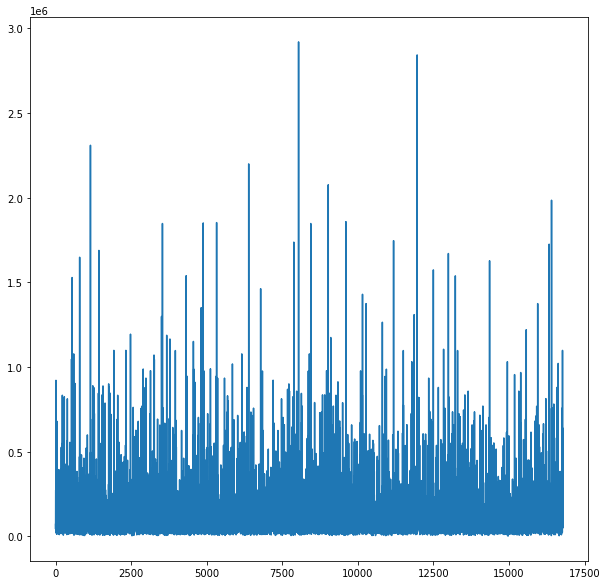

In [35]:
print(df.price.describe())
print(df.price.plot(figsize=(10,10)))

AxesSubplot(0.125,0.125;0.775x0.755)


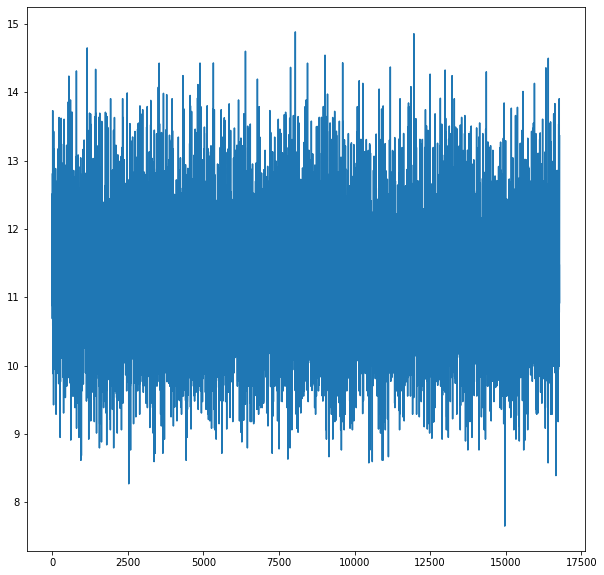

In [36]:
print(df.price.apply(np.log).plot(figsize=(10,10)))

### Corelations

#### Make vs price

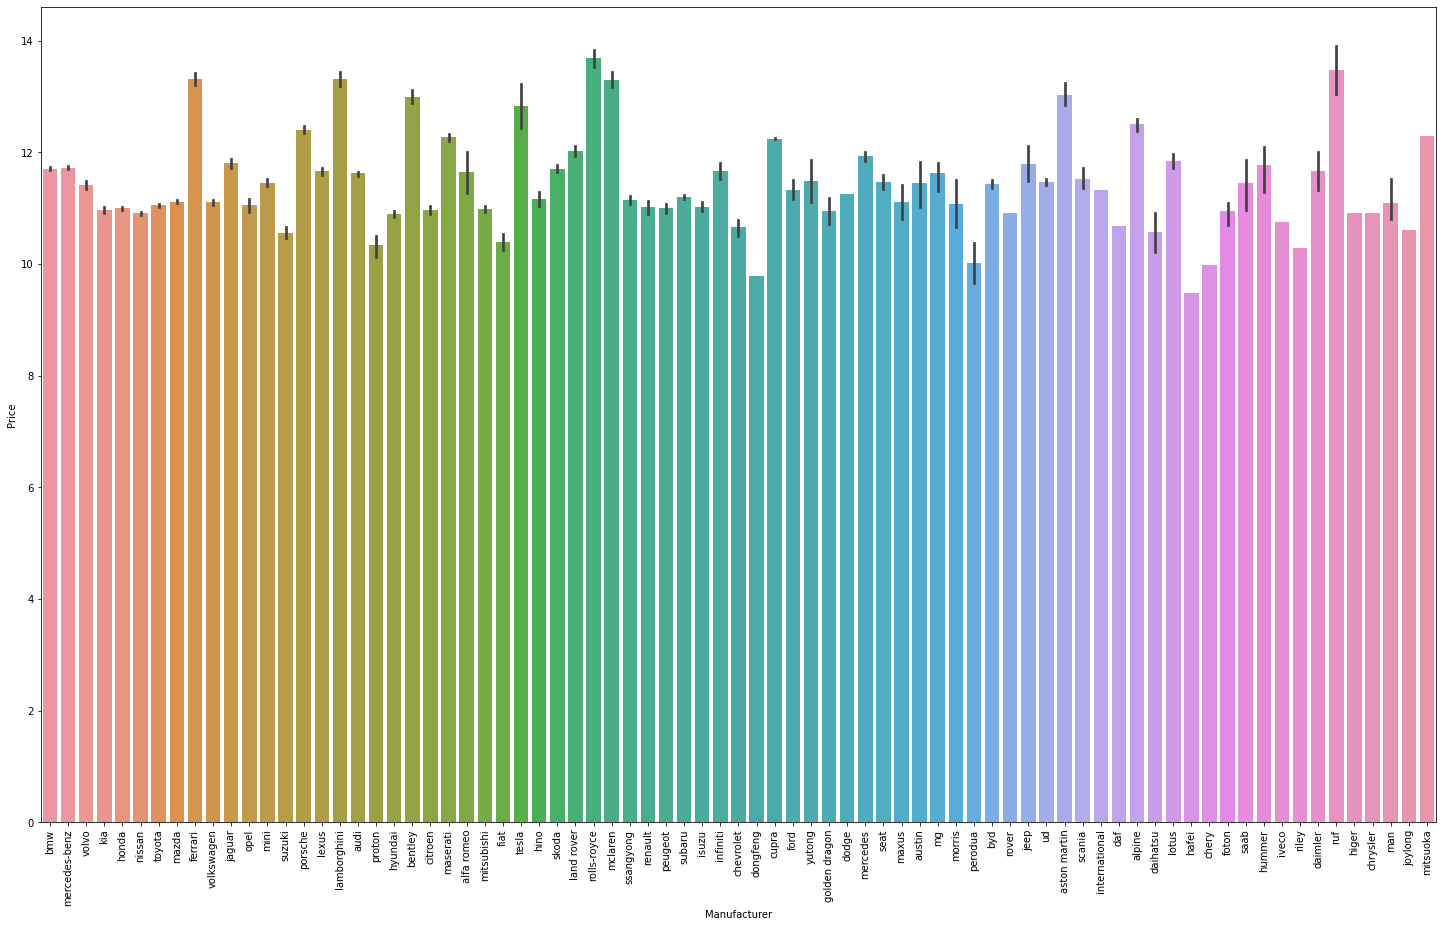

In [37]:
tdf=df.sort_values(by=['price'],ascending=False)
plt.figure(figsize=(25,15))
sns.barplot(x=df.make, y=np.log(df.price))
plt.xticks(rotation= 90)
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.show()

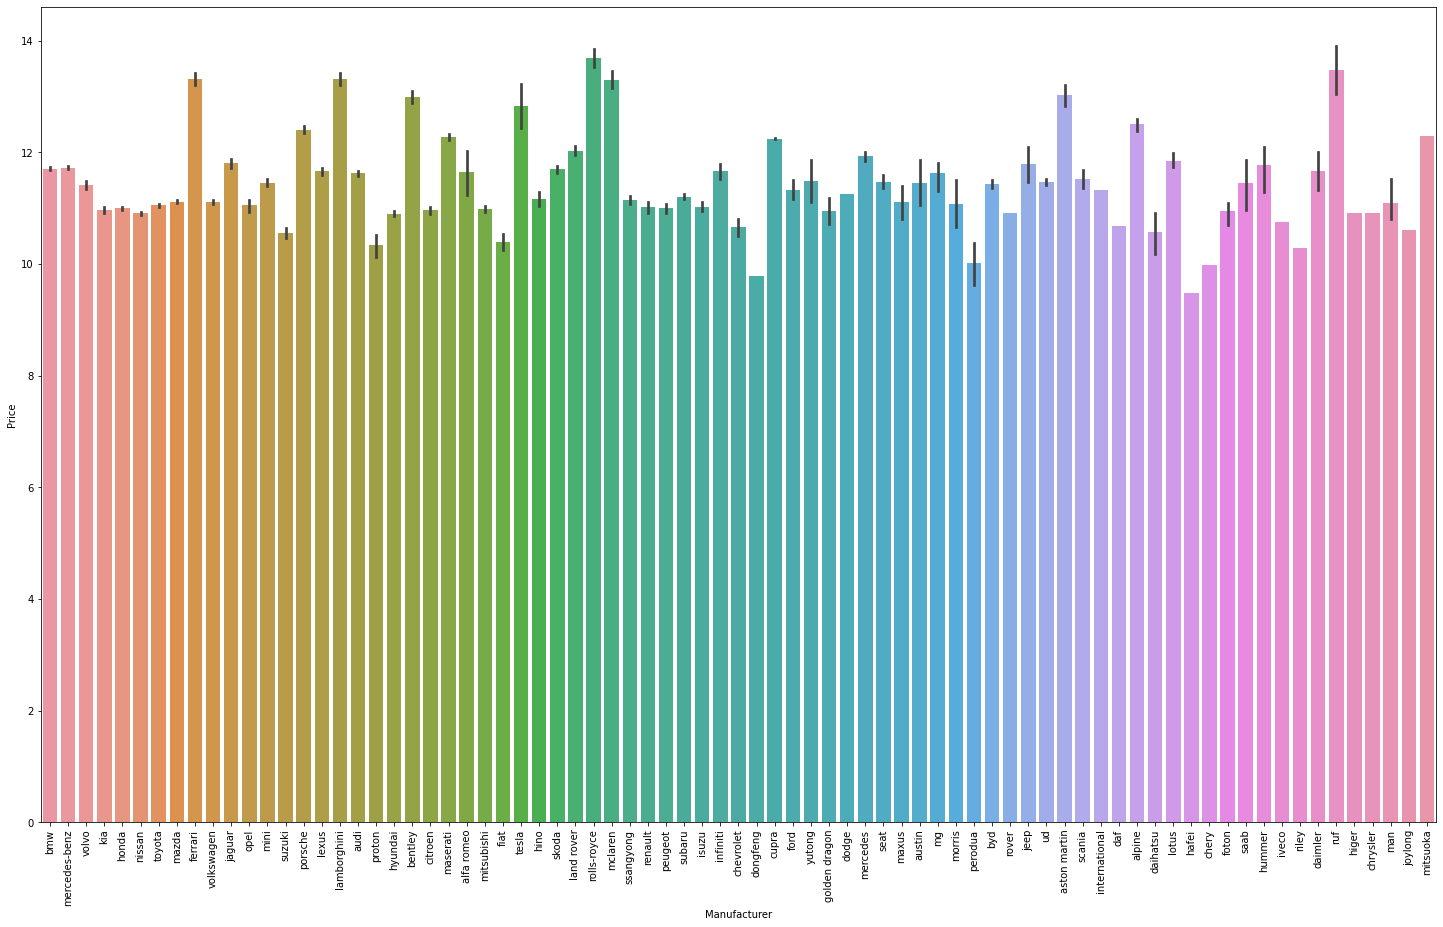

In [38]:
tdf=df.sort_values(by=['price'],ascending=False)
plt.figure(figsize=(25,15))
sns.barplot(x=df.make, y=np.log(df.price))
plt.xticks(rotation= 90)
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.show()